In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
import pandas as pd
from pyprojroot import here
import numpy as np

test_pd = pd.read_csv(here(r"data/sign_language_mnist/sign_mnist_test.csv"))
train_pd = pd.read_csv(here(r"data/sign_language_mnist/sign_mnist_train.csv"))
test_pd

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


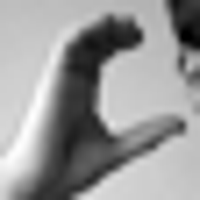

In [2]:
# remove label
train_label = train_pd["label"].to_numpy()
test_label = test_pd["label"].to_numpy()

train = train_pd.drop(columns=["label"]).to_numpy().reshape(-1, 28, 28, 1) # obs, width, height, channels
test = test_pd.drop(columns=["label"]).to_numpy().reshape(-1, 28, 28, 1)
keras.utils.array_to_img(train[2]).resize((200, 200))

In [3]:
from keras import layers
from tqdm.keras import TqdmCallback

class CNN:
  def __init__(self, epochs=10, batch_size=32, lr=0.01, seed=None, validation_split=0.2):
    self.epochs = epochs
    self.batch_size = batch_size
    self.lr = lr
    self.validation_split = validation_split
    self.__make_model(seed)
    
  def __make_model(self, seed=None):
    if seed is not None: keras.utils.set_random_seed(seed)
    self.model = keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Rescaling(1./255),
      layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D((2, 2)),
      layers.Flatten(),
      layers.Dense(128, activation="relu"),
      layers.Dense(26, activation="softmax")
    ])
    self.model.compile(
      loss="sparse_categorical_crossentropy",
      optimizer=keras.optimizers.Adam(learning_rate=self.lr),
      metrics=["accuracy"]
    )
      
  def summary(self):
    return self.model.summary()
  
  def fit(self, x, y, reset=True, seed=None):
    if seed is not None: keras.utils.set_random_seed(seed)
    if reset:
      self.__make_model()
    history = self.model.fit(
      x, y,
      batch_size=self.batch_size,
      epochs=self.epochs,
      validation_split=0 if self.validation_split is None else self.validation_split,
      verbose=0,
      callbacks=[
        TqdmCallback(verbose=1),
        keras.callbacks.EarlyStopping(
          monitor="val_loss",
          patience=5,
          restore_best_weights=True
        )
      ])
    self.history = pd.DataFrame(history.history)
    return self.history
    
  def evaluate(self, x, y):
    return self.model.evaluate(x, y, verbose=1)
  
  def save(self, path):
    self.model.save(path)
    
  @staticmethod
  def load(path):
    return keras.models.load_model(path) # doesn't return a «CNN» object but that's ok for now
  
CNN().summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,610 (951.60 KB)

 Trainable params: 243,610 (951.60 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
keras.utils.set_random_seed(1)
model = CNN(epochs=10)
history = model.fit(train, train_label)
history

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

,accuracy,loss,val_accuracy,val_loss
0,0.043981,3.194646,0.047897,3.178841
1,0.043253,3.180079,0.043708,3.179129
2,0.041750,3.179489,0.047897,3.178752
3,0.042114,3.178613,0.042433,3.177075
4,0.045074,3.178277,0.041887,3.179461
5,0.046030,3.178121,0.040976,3.177558
6,0.043936,3.178115,0.047897,3.176626
7,0.043799,3.177924,0.044072,3.177872
8,0.042570,3.177927,0.044072,3.179351
9,0.045484,3.177841,0.047897,3.176861


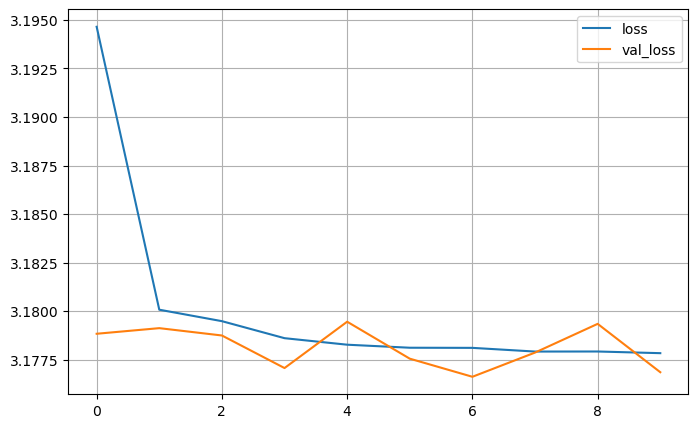

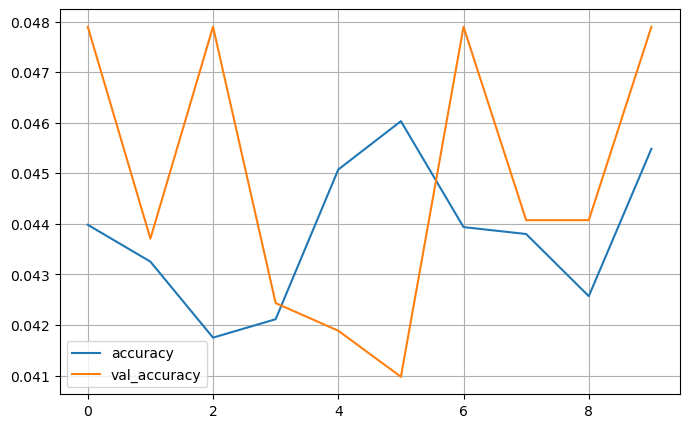

In [8]:
import matplotlib.pyplot as plt
history.loc[:, ["loss", "val_loss"]].plot(figsize=(8, 5), grid=True)
plt.show()
history.loc[:, ["accuracy", "val_accuracy"]].plot(figsize=(8, 5), grid=True)
plt.show()

In [10]:
model.evaluate(train, train_label)

858/858 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.0462 - loss: 3.1774


[3.1770126819610596, 0.04713166877627373]

In [11]:
model.save(here(r"models/sign_language_mnist/CNN.h5"))

c:\Users\plancha\AML-homework\.pixi\envs\gpu\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


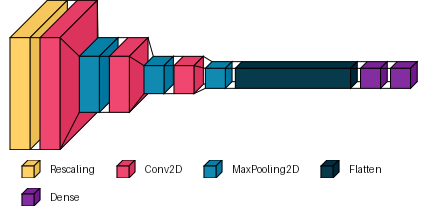

In [12]:
import visualkeras

visualkeras.layered_view(model.model, legend=True)